In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

most_recent_date= dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
one_year_date = most_recent_date - dt.timedelta(days=365)
print(one_year_date)

2016-08-23 00:00:00


In [13]:
# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>one_year_date).\
order_by(Measurement.date).all()

In [16]:

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
results_df = pd.DataFrame(precip_scores)
results_df = results_df.set_index('date')
results_df = results_df.sort_index()
results_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


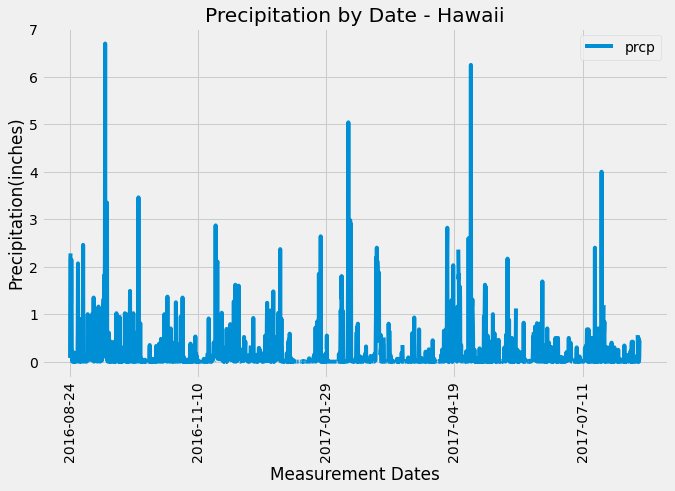

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data
results_df.plot(figsize=(10,6))
plt.xticks(rotation='vertical')
plt.title("Precipitation by Date - Hawaii")
plt.xlabel('Measurement Dates')
plt.ylabel('Precipitation(inches)')
plt.tight_layout
plt.show()

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [25]:
from sqlalchemy import distinct
# Design a query to calculate the total number stations in the dataset
stations = session.query(func.count(distinct(Measurement.station))).all()
stations

[(9,)]

In [27]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*station).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*station).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temp_summary:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station = [Measurement.date, 
       Measurement.tobs]
station_temps = session.query(*station).\
        filter(func.strftime(Measurement.date) >= one_year_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Create a dataframe of results
active_station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])
active_station_temps_df.head()

,Measurement Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


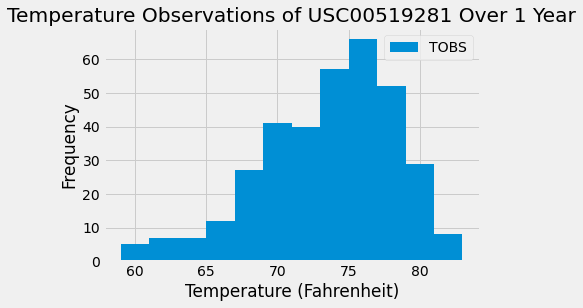

In [32]:
#plotting the results as a histogram
plt.hist(active_station_temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations of USC00519281 Over 1 Year")
plt.figsize=(10,7)
plt.show()

# Close session

In [33]:
# Close Session
session.close()